## Example use case of Octrac

In [1]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import ocetrac

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings('ignore')

### Import NOAA OISST v2.1 dataset and resample monthly means

In [ ]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},)

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True, decode_timedelta=True).resample(time='MS').mean()
print(ds)

### Feature thresholding

In [ ]:
# Compute values of the monthly threshold defined using the 90th percentile

if ds.anom.chunks:
    ds['anom'] = ds.anom.chunk({'time': -1})
    
threshold = ds.anom.quantile(.9, dim=('time'))
features_ssta = ds.anom.where(ds.anom>=threshold, other=np.nan).isel(zlev=0)


In [ ]:
%%time 
# Just take the first 100 time steps
# features_ssta= features_ssta[:100,:,:].load()
features_ssta.load()

In [ ]:
features_ssta.isel(time=-1).plot()

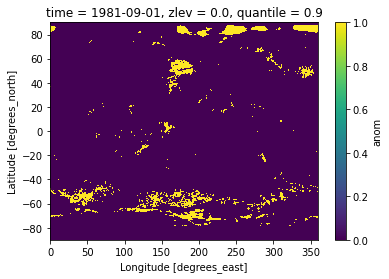

In [4]:
# Binary conversion
binary_out = np.isfinite(features_ssta)
binary_out.isel(time=0).plot()

In [ ]:
mask = np.isfinite(ds.sst.isel(time=0, zlev=0))
mask.plot()

In [ ]:
%%time
Tracker = ocetrac.Tracker(binary_out, mask, radius=8, min_size_quartile=0.75, timedim='time', xdim='lon', ydim='lat', positive=True)
blobs = Tracker.track()

In [ ]:
blobs.attrs

In [ ]:
blobs.sel(time=slice('01-01-2014', '03-01-2014'), col='time', col_wrap=4).plot()

In [ ]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())

plt.figure(figsize=(16,3))
ax1 = plt.subplot(121);blobs.isel(time=0).plot(cmap= cm)
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal')
ax2 = plt.subplot(122); features_ssta.isel(time=0).plot(cmap='Reds', vmin=0, vmax=3);
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

In [ ]:
id = 35
event = blobs.where(blobs==id, drop=True)


In [ ]:
# Create intensity image for the Indian Ocean marine heatwave
event_intensity = ds.anom.isel(zlev=0).where((ds.time==event.time) & 
                                             (ds.lat==event.lat) & 
                                             (ds.lon==event.lon), 
                                             drop=True).load();
event_intensity = event_intensity.expand_dims(dim='intensity', axis=3)
events_contour = event.fillna(0)

plt.rc('font', size=12); plt.figure(figsize=(15,6));
for i in enumerate(range(1,len(event.time))):
    ax = plt.subplot(2,3,i[1],projection=ccrs.PlateCarree())
    event_intensity.isel(time=i[0], intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2,  
                                                      cmap='RdBu_r', extend='both', add_colorbar=True, add_labels=False)
    plt.title(event.isel(time=i[0]).time.values.astype('datetime64[D]'))
    ax.coastlines(resolution='110m', color='black', linewidth=1) 
    ax.add_feature(cfeature.LAND, facecolor='w');
    events_contour.isel(time=i[0]).plot.contour(levels=[34,35], transform=ccrs.PlateCarree(), colors='b', linewidths=4, add_colorbar=False, add_labels=False)

In [ ]:
mo = Tracker._morphological_operations()

In [ ]:
mo.isel(time=0).plot()